<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/beras_medium1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f9e70e36dc0>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.beras_kualitas_medium_i.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


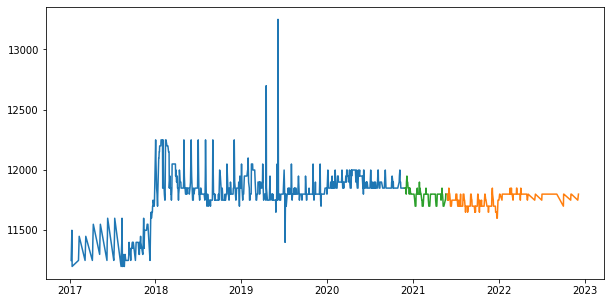

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [10]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_beras_medium1_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [11]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [12]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [13]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 27s 370ms/step - loss: 0.0950 - mae: 0.3064 - mape: 90.6925 - val_loss: 0.0882 - val_mae: 0.2715 - val_mape: 10007414.0000
Epoch 2/30
44/44 [==============================] - 7s 166ms/step - loss: 0.0598 - mae: 0.2424 - mape: 71.6643 - val_loss: 0.0603 - val_mae: 0.2288 - val_mape: 20405968.0000
Epoch 3/30
44/44 [==============================] - 7s 166ms/step - loss: 0.0353 - mae: 0.1853 - mape: 54.6122 - val_loss: 0.0442 - val_mae: 0.1953 - val_mape: 28444338.0000
Epoch 4/30
44/44 [==============================] - 7s 168ms/step - loss: 0.0210 - mae: 0.1416 - mape: 41.5846 - val_loss: 0.0352 - val_mae: 0.1734 - val_mape: 34553840.0000
Epoch 5/30
44/44 [==============================] - 7s 168ms/step - loss: 0.0125 - mae: 0.1080 - mape: 31.5880 - val_loss: 0.0301 - val_mae: 0.1615 - val_mape: 39301884.0000
Epoch 6/30
44/44 [==============================] - 7s 167ms/step - loss: 0.0075 - mae: 0.0820 - mape: 23.8518 - val_loss: 0.0274

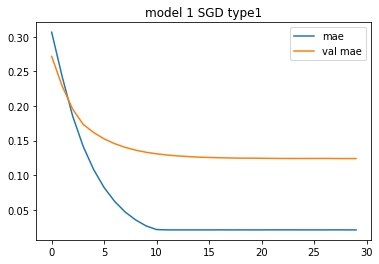

In [14]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 3s 21ms/step
126.84139 1.0815961 136.8665094398553


,date,actual,prediction
0,2021-05-20,11800,11889.591797
1,2021-05-21,11800,11889.264648
2,2021-05-24,11800,11889.401367
3,2021-05-25,11800,11888.970703
4,2021-05-27,11750,11889.048828
...,...,...,...
229,2022-11-02,11800,11880.389648
230,2022-11-03,11800,11880.402344
231,2022-11-04,11800,11880.273438
232,2022-12-01,11750,11880.318359


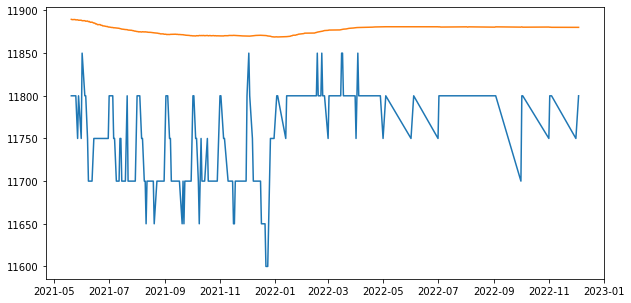

In [15]:
prediction = forecast_predict(model, test_beras_medium1_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_beras_medium1 = pd.DataFrame()
data_new_beras_medium1['date'] = y_test
data_new_beras_medium1['actual'] = x_test
data_new_beras_medium1['prediction'] = data_result
data_new_beras_medium1.to_csv('beras_medium1_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_beras_medium1.date, data_new_beras_medium1.actual)
plt.plot(data_new_beras_medium1.date, data_new_beras_medium1.prediction)
data_new_beras_medium1

#### type2

In [16]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 24s 33ms/step - loss: 0.0038 - mae: 0.0418 - mape: 12.4373 - val_loss: 0.0254 - val_mae: 0.1270 - val_mape: 53468892.0000
Epoch 2/30
718/718 [==============================] - 23s 32ms/step - loss: 0.0037 - mae: 0.0410 - mape: 12.1071 - val_loss: 0.0254 - val_mae: 0.1271 - val_mape: 53443888.0000
Epoch 3/30
718/718 [==============================] - 23s 32ms/step - loss: 0.0038 - mae: 0.0413 - mape: 12.2450 - val_loss: 0.0254 - val_mae: 0.1272 - val_mape: 53387652.0000
Epoch 4/30
718/718 [==============================] - 23s 32ms/step - loss: 0.0037 - mae: 0.0410 - mape: 12.1432 - val_loss: 0.0254 - val_mae: 0.1276 - val_mape: 53262232.0000
Epoch 5/30
718/718 [==============================] - 24s 34ms/step - loss: 0.0038 - mae: 0.0412 - mape: 12.1945 - val_loss: 0.0253 - val_mae: 0.1279 - val_mape: 53119320.0000
Epoch 6/30
718/718 [==============================] - 23s 32ms/step - loss: 0.0037 - mae: 0.0410 - mape: 12.1161 - val_l

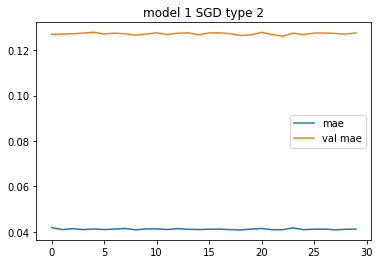

In [17]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 5ms/step
104.70869 0.89320296 116.53849032213563


,date,actual,prediction
0,2021-05-20,11800,11889.591797
1,2021-05-21,11800,11889.264648
2,2021-05-24,11800,11889.401367
3,2021-05-25,11800,11888.970703
4,2021-05-27,11750,11889.048828
...,...,...,...
229,2022-11-02,11800,11880.389648
230,2022-11-03,11800,11880.402344
231,2022-11-04,11800,11880.273438
232,2022-12-01,11750,11880.318359


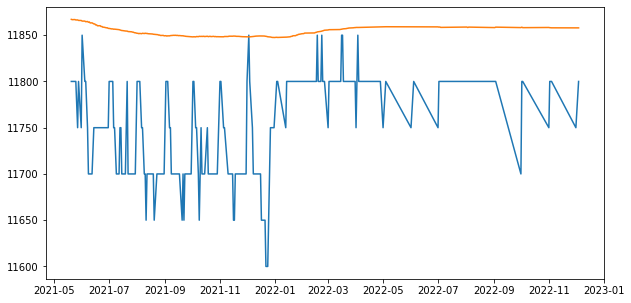

In [18]:
win_size1 = 60
test_beras_medium1_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_beras_medium1_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_beras_medium1_1 = pd.DataFrame()
data_new_beras_medium1_1['actual'] = x_test
data_new_beras_medium1_1['prediction'] = data_result_1
data_new_beras_medium1_1.to_csv('beras_medium1_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_medium1_1.actual)
plt.plot(y_test, data_new_beras_medium1_1.prediction)
data_new_beras_medium1

#### type3

In [19]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 10s 113ms/step - loss: 0.0027 - mae: 0.0305 - mape: 9.5288 - val_loss: 0.0253 - val_mae: 0.1285 - val_mape: 52964428.0000
Epoch 2/30
84/84 [==============================] - 10s 113ms/step - loss: 0.0027 - mae: 0.0297 - mape: 9.2321 - val_loss: 0.0253 - val_mae: 0.1292 - val_mape: 52667032.0000
Epoch 3/30
84/84 [==============================] - 10s 112ms/step - loss: 0.0027 - mae: 0.0293 - mape: 9.0863 - val_loss: 0.0253 - val_mae: 0.1295 - val_mape: 52572748.0000
Epoch 4/30
84/84 [==============================] - 10s 114ms/step - loss: 0.0027 - mae: 0.0293 - mape: 9.0758 - val_loss: 0.0253 - val_mae: 0.1296 - val_mape: 52535620.0000
Epoch 5/30
84/84 [==============================] - 10s 113ms/step - loss: 0.0027 - mae: 0.0291 - mape: 8.9925 - val_loss: 0.0253 - val_mae: 0.1296 - val_mape: 52518712.0000
Epoch 6/30
84/84 [==============================] - 10s 114ms/step - loss: 0.0027 - mae: 0.0291 - mape: 9.0049 - val_loss: 0.0253 

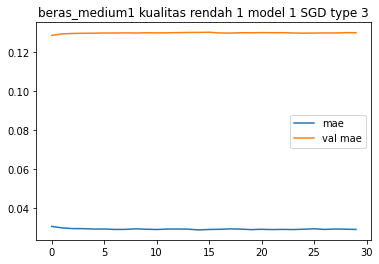

In [20]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('beras_medium1 kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 10ms/step
97.632454 0.832965 110.13183240013988


,actual,prediction
0,11800,11860.317383
1,11800,11859.966797
2,11800,11860.082031
3,11800,11859.612305
4,11750,11859.661133
...,...,...
229,11800,11850.845703
230,11800,11850.830078
231,11800,11850.714844
232,11750,11850.738281


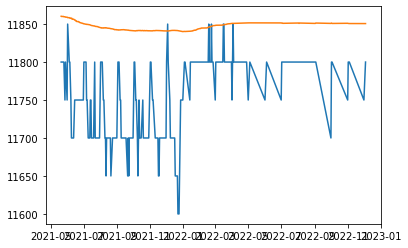

In [21]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_beras_medium1_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_beras_medium1_2 = pd.DataFrame()
# data_new_beras_medium11['date'] = date_test
data_new_beras_medium1_2['actual'] = x_test
data_new_beras_medium1_2['prediction'] = data_result_2
data_new_beras_medium1_2.to_csv('beras_medium1_model1_sgd_type3')

plt.plot(y_test, data_new_beras_medium1_2.actual)
plt.plot(y_test, data_new_beras_medium1_2.prediction)
data_new_beras_medium1_2

### Adam

In [22]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [23]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 12s 195ms/step - loss: 0.0685 - mae: 0.2568 - mape: 75.8380 - val_loss: 0.0504 - val_mae: 0.2094 - val_mape: 25471308.0000
Epoch 2/30
44/44 [==============================] - 8s 171ms/step - loss: 0.0111 - mae: 0.0848 - mape: 24.5883 - val_loss: 0.0261 - val_mae: 0.1250 - val_mape: 55112408.0000
Epoch 3/30
44/44 [==============================] - 8s 174ms/step - loss: 6.8368e-04 - mae: 0.0219 - mape: 6.4668 - val_loss: 0.0256 - val_mae: 0.1302 - val_mape: 53014264.0000
Epoch 4/30
44/44 [==============================] - 8s 173ms/step - loss: 7.1068e-04 - mae: 0.0218 - mape: 6.3122 - val_loss: 0.0257 - val_mae: 0.1295 - val_mape: 53273204.0000
Epoch 5/30
44/44 [==============================] - 8s 172ms/step - loss: 6.6474e-04 - mae: 0.0211 - mape: 6.1227 - val_loss: 0.0257 - val_mae: 0.1291 - val_mape: 53461548.0000
Epoch 6/30
44/44 [==============================] - 8s 173ms/step - loss: 6.6785e-04 - mae: 0.0214 - mape: 6.2398 - val_

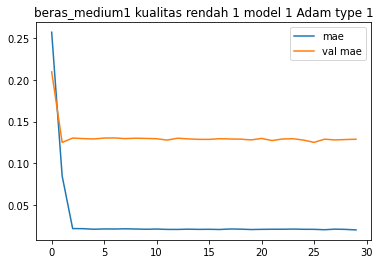

In [24]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('beras_medium1 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 3s 20ms/step
69.25024 0.5909426 82.60927008457494


,actual,prediction
0,11800,11874.467773
1,11800,11876.613281
2,11800,11873.737305
3,11800,11875.913086
4,11750,11872.668945
...,...,...
229,11800,11836.300781
230,11800,11834.070312
231,11800,11835.842773
232,11750,11833.793945


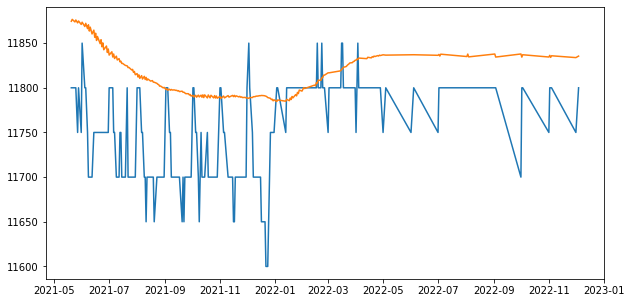

In [25]:
prediction_a = forecast_predict(model_a, test_beras_medium1_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_beras_medium1_a = pd.DataFrame()
# data_new_beras_medium11['date'] = date_test
data_new_beras_medium1_a['actual'] = x_test
data_new_beras_medium1_a['prediction'] = data_result_a
data_new_beras_medium1_a.to_csv('beras_medium1_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_beras_medium1_a.actual)
plt.plot(y_test, data_new_beras_medium1_a.prediction)
data_new_beras_medium1_a

#### Type 2

In [26]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 24s 33ms/step - loss: 0.0042 - mae: 0.0413 - mape: 12.0984 - val_loss: 0.0259 - val_mae: 0.1283 - val_mape: 54083372.0000
Epoch 2/30
718/718 [==============================] - 23s 31ms/step - loss: 0.0039 - mae: 0.0404 - mape: 11.8395 - val_loss: 0.0262 - val_mae: 0.1261 - val_mape: 55075520.0000
Epoch 3/30
718/718 [==============================] - 23s 32ms/step - loss: 0.0037 - mae: 0.0390 - mape: 11.4773 - val_loss: 0.0259 - val_mae: 0.1313 - val_mape: 53136952.0000
Epoch 4/30
718/718 [==============================] - 23s 32ms/step - loss: 0.0037 - mae: 0.0388 - mape: 11.3835 - val_loss: 0.0263 - val_mae: 0.1267 - val_mape: 55101532.0000
Epoch 5/30
718/718 [==============================] - 22s 31ms/step - loss: 0.0036 - mae: 0.0385 - mape: 11.3332 - val_loss: 0.0262 - val_mae: 0.1286 - val_mape: 54463132.0000
Epoch 6/30
718/718 [==============================] - 23s 32ms/step - loss: 0.0035 - mae: 0.0384 - mape: 11.3366 - val_l

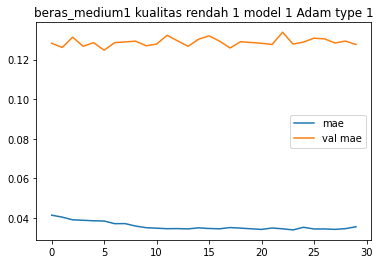

In [27]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('beras_medium1 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 6ms/step
152.91426 1.3033507 160.6283559960694


,actual,prediction
0,11800,11913.707031
1,11800,11915.943359
2,11800,11911.824219
3,11800,11913.703125
4,11750,11909.691406
...,...,...
229,11800,11899.607422
230,11800,11899.131836
231,11800,11899.162109
232,11750,11899.277344


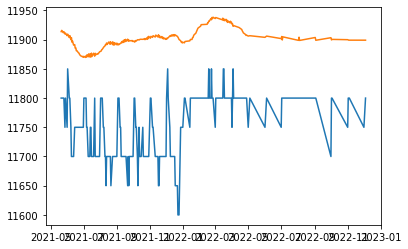

In [28]:
prediction_a1 = forecast_predict(model_a, test_beras_medium1_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_beras_medium1_a1 = pd.DataFrame()
data_new_beras_medium1_a1['actual'] = x_test
data_new_beras_medium1_a1['prediction'] = data_result_a1
data_new_beras_medium1_a1.to_csv('beras_medium1_model1_adam_type2.csv')

plt.plot(y_test, data_new_beras_medium1_a1.actual)
plt.plot(y_test, data_new_beras_medium1_a1.prediction)
data_new_beras_medium1_a1

#### Type 3

In [29]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 11s 126ms/step - loss: 0.0026 - mae: 0.0258 - mape: 7.9028 - val_loss: 0.0263 - val_mae: 0.1286 - val_mape: 54551192.0000
Epoch 2/30
84/84 [==============================] - 10s 113ms/step - loss: 0.0026 - mae: 0.0264 - mape: 8.0909 - val_loss: 0.0261 - val_mae: 0.1302 - val_mape: 53861112.0000
Epoch 3/30
84/84 [==============================] - 10s 114ms/step - loss: 0.0026 - mae: 0.0264 - mape: 8.1236 - val_loss: 0.0260 - val_mae: 0.1332 - val_mape: 52675176.0000
Epoch 4/30
84/84 [==============================] - 10s 114ms/step - loss: 0.0026 - mae: 0.0256 - mape: 7.7924 - val_loss: 0.0260 - val_mae: 0.1323 - val_mape: 53051136.0000
Epoch 5/30
84/84 [==============================] - 10s 112ms/step - loss: 0.0026 - mae: 0.0260 - mape: 7.9764 - val_loss: 0.0260 - val_mae: 0.1325 - val_mape: 52937292.0000
Epoch 6/30
84/84 [==============================] - 10s 112ms/step - loss: 0.0026 - mae: 0.0252 - mape: 7.6593 - val_loss: 0.0263 

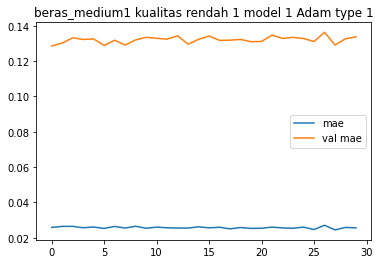

In [30]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('beras_medium1 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 9ms/step
68.557594 0.5850458 81.00612739652013


,actual,prediction
0,11800,11858.187500
1,11800,11859.826172
2,11800,11856.940430
3,11800,11858.407227
4,11750,11855.321289
...,...,...
229,11800,11814.833008
230,11800,11814.681641
231,11800,11813.388672
232,11750,11813.768555


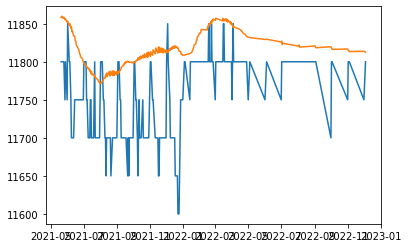

In [31]:
prediction_a2 = forecast_predict(model_a, test_beras_medium1_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_beras_medium1_a2 = pd.DataFrame()
# data_new_beras_medium11['date'] = date_test
data_new_beras_medium1_a2['actual'] = x_test
data_new_beras_medium1_a2['prediction'] = data_result_a2
data_new_beras_medium1_a2.to_csv('beras_medium1_model1_adam_type3.csv')

plt.plot(y_test, data_new_beras_medium1_a2.actual)
plt.plot(y_test, data_new_beras_medium1_a2.prediction)
data_new_beras_medium1_a2

## model 1

### Adam

In [32]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [33]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 17s 301ms/step - loss: 0.0594 - mae: 0.2226 - mape: 65.5444 - val_loss: 0.0277 - val_mae: 0.1141 - val_mape: 59096284.0000
Epoch 2/15
44/44 [==============================] - 12s 278ms/step - loss: 0.0015 - mae: 0.0297 - mape: 8.7652 - val_loss: 0.0261 - val_mae: 0.1234 - val_mape: 55464228.0000
Epoch 3/15
44/44 [==============================] - 12s 278ms/step - loss: 6.7286e-04 - mae: 0.0209 - mape: 6.0641 - val_loss: 0.0258 - val_mae: 0.1264 - val_mape: 54273928.0000
Epoch 4/15
44/44 [==============================] - 12s 278ms/step - loss: 7.1277e-04 - mae: 0.0216 - mape: 6.3079 - val_loss: 0.0259 - val_mae: 0.1250 - val_mape: 54833236.0000
Epoch 5/15
44/44 [==============================] - 12s 278ms/step - loss: 6.9971e-04 - mae: 0.0213 - mape: 6.1858 - val_loss: 0.0261 - val_mae: 0.1238 - val_mape: 55322964.0000
Epoch 6/15
44/44 [==============================] - 12s 278ms/step - loss: 6.9657e-04 - mae: 0.0210 - mape: 6.1253 - 

17/17 [==============================] - 0s 13ms/step - loss: 0.0955 - mae: 0.2901 - mape: 36.4815


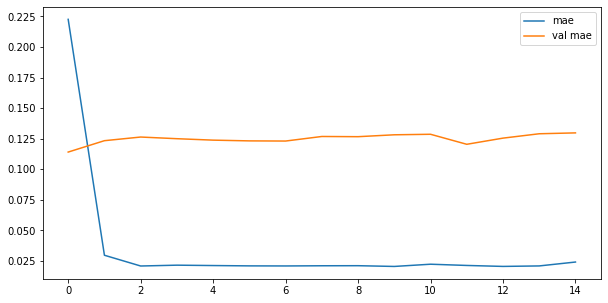

In [34]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [35]:
prediction1 = forecast_predict(model1, test_beras_medium1_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_beras_medium11 = pd.DataFrame()
data_new_beras_medium11['actual'] = x_test
data_new_beras_medium11['prediction'] = data_result1
data_new_beras_medium11.to_csv('beras_medium1_model2_adam_type1.csv')

data_new_beras_medium11

131/131 [==============================] - 4s 29ms/step
52.28049 0.44613755 64.10898846763806


,actual,prediction
0,11800,11850.666016
1,11800,11850.731445
2,11800,11850.287109
3,11800,11850.100586
4,11750,11849.423828
...,...,...
229,11800,11809.041992
230,11800,11809.368164
231,11800,11808.600586
232,11750,11808.843750


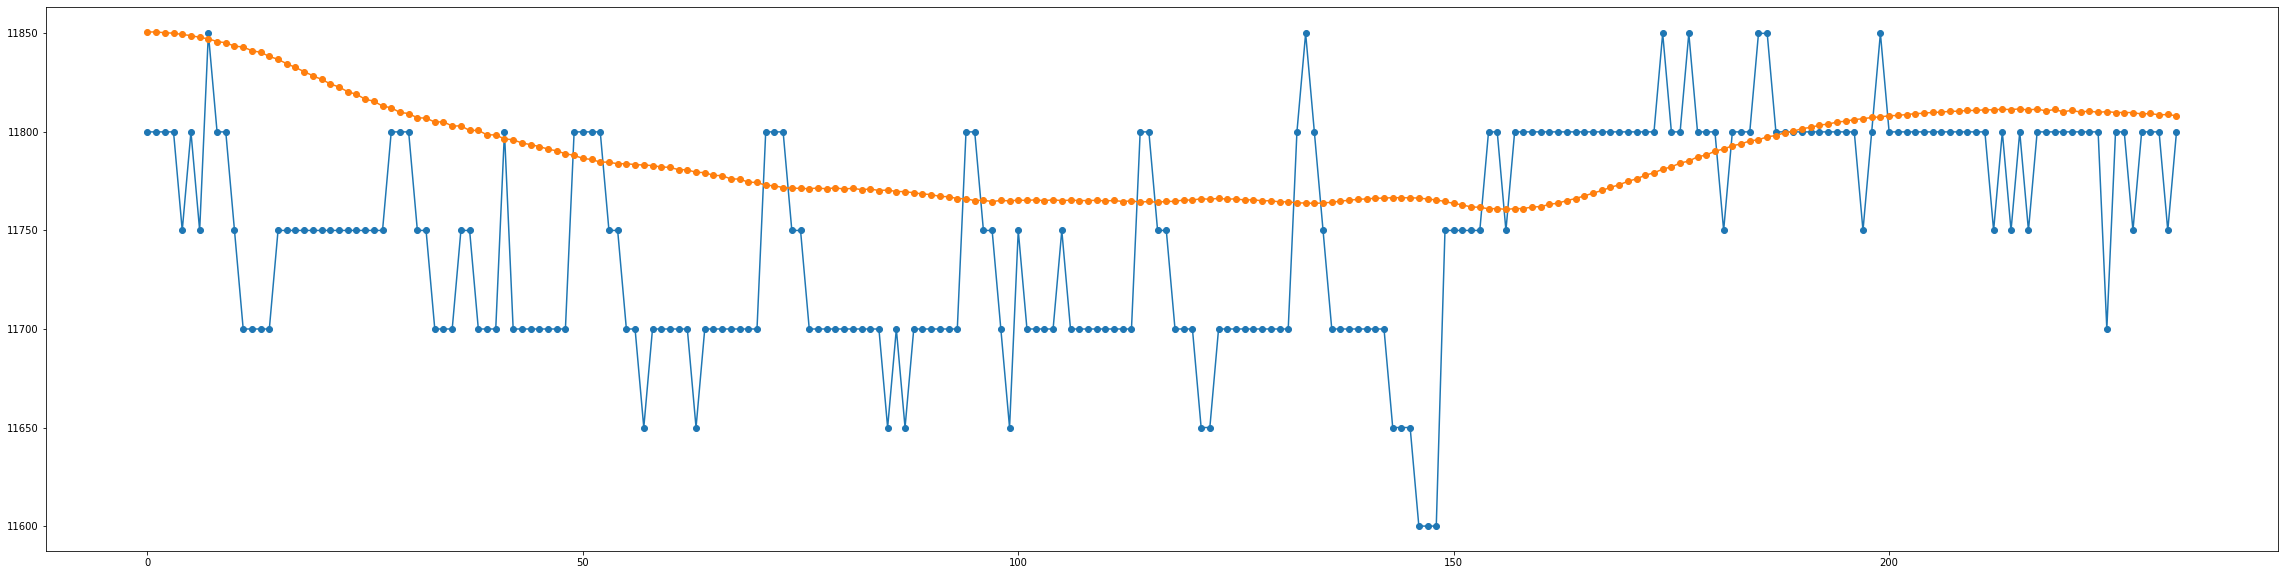

In [36]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_beras_medium11['actual'], '-o')
plt.plot(range(len(x_test)), data_new_beras_medium11['prediction'], '-o')

#### Type 2

In [37]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 26s 37ms/step - loss: 0.0043 - mae: 0.0418 - mape: 12.2113 - val_loss: 0.0273 - val_mae: 0.1189 - val_mape: 57989080.0000
Epoch 2/15
718/718 [==============================] - 26s 37ms/step - loss: 0.0037 - mae: 0.0390 - mape: 11.4613 - val_loss: 0.0271 - val_mae: 0.1206 - val_mape: 57544392.0000
Epoch 3/15
718/718 [==============================] - 26s 37ms/step - loss: 0.0036 - mae: 0.0381 - mape: 11.2277 - val_loss: 0.0267 - val_mae: 0.1249 - val_mape: 56113616.0000
Epoch 4/15
718/718 [==============================] - 26s 37ms/step - loss: 0.0035 - mae: 0.0376 - mape: 11.1510 - val_loss: 0.0264 - val_mae: 0.1285 - val_mape: 54886192.0000
Epoch 5/15
718/718 [==============================] - 27s 37ms/step - loss: 0.0034 - mae: 0.0365 - mape: 10.7887 - val_loss: 0.0266 - val_mae: 0.1283 - val_mape: 55223684.0000
Epoch 6/15
718/718 [==============================] - 27s 37ms/step - loss: 0.0034 - mae: 0.0366 - mape: 10.8439 - val_l

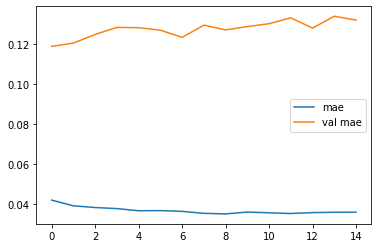

In [38]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 7ms/step
78.80022 0.67227226 64.10898846763806


,actual,prediction
0,11800,11878.029297
1,11800,11876.604492
2,11800,11877.375000
3,11800,11875.251953
4,11750,11875.728516
...,...,...
229,11800,11840.517578
230,11800,11840.950195
231,11800,11839.290039
232,11750,11840.708984


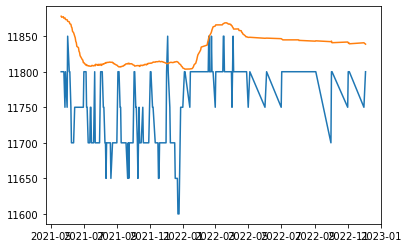

In [39]:
prediction1_1 = forecast_predict(model1, test_beras_medium1_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_beras_medium11_1 = pd.DataFrame()
data_new_beras_medium11_1['actual'] = x_test
data_new_beras_medium11_1['prediction'] = data_result1_1
data_new_beras_medium11_1.to_csv('beras_medium1_model2_adam_type2.csv')

plt.plot(y_test, data_new_beras_medium11_1.actual)
plt.plot(y_test, data_new_beras_medium11_1.prediction)
data_new_beras_medium11_1

#### Type 3

In [40]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 16s 184ms/step - loss: 0.0026 - mae: 0.0262 - mape: 8.0812 - val_loss: 0.0264 - val_mae: 0.1360 - val_mape: 52601416.0000
Epoch 2/15
84/84 [==============================] - 16s 184ms/step - loss: 0.0026 - mae: 0.0256 - mape: 7.7909 - val_loss: 0.0265 - val_mae: 0.1345 - val_mape: 53270708.0000
Epoch 3/15
84/84 [==============================] - 16s 184ms/step - loss: 0.0026 - mae: 0.0258 - mape: 7.8624 - val_loss: 0.0266 - val_mae: 0.1333 - val_mape: 53857400.0000
Epoch 4/15
84/84 [==============================] - 16s 183ms/step - loss: 0.0026 - mae: 0.0255 - mape: 7.8073 - val_loss: 0.0265 - val_mae: 0.1363 - val_mape: 52632244.0000
Epoch 5/15
84/84 [==============================] - 16s 184ms/step - loss: 0.0026 - mae: 0.0253 - mape: 7.7119 - val_loss: 0.0266 - val_mae: 0.1343 - val_mape: 53506496.0000
Epoch 6/15
84/84 [==============================] - 16s 185ms/step - loss: 0.0026 - mae: 0.0251 - mape: 7.6901 - val_loss: 0.0265 

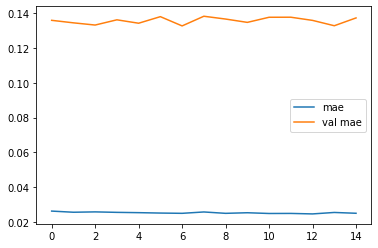

In [41]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 13ms/step
60.445633 0.5158136 64.10898846763806


,actual,prediction
0,11800,11862.021484
1,11800,11858.825195
2,11800,11861.600586
3,11800,11857.296875
4,11750,11860.101562
...,...,...
229,11800,11818.220703
230,11800,11819.086914
231,11800,11816.626953
232,11750,11818.372070


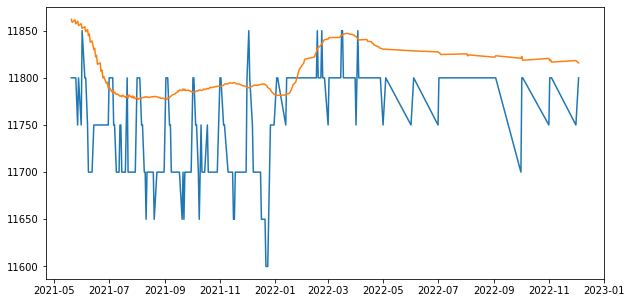

In [42]:
prediction1_2 = forecast_predict(model1, test_beras_medium1_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_beras_medium11_2 = pd.DataFrame()
data_new_beras_medium11_2['actual'] = x_test
data_new_beras_medium11_2['prediction'] = data_result1_2
data_new_beras_medium11_2.to_csv('beras_medium1_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_medium11_2.actual)
plt.plot(y_test, data_new_beras_medium11_2.prediction)

data_new_beras_medium11_2

### SGD

In [43]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [44]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [45]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 17s 303ms/step - loss: 0.0988 - mae: 0.3125 - mape: 92.4750 - val_loss: 0.0907 - val_mae: 0.2749 - val_mape: 9324615.0000
Epoch 2/15
44/44 [==============================] - 12s 275ms/step - loss: 0.0646 - mae: 0.2520 - mape: 74.4661 - val_loss: 0.0643 - val_mae: 0.2358 - val_mape: 18729340.0000
Epoch 3/15
44/44 [==============================] - 12s 275ms/step - loss: 0.0398 - mae: 0.1966 - mape: 57.9668 - val_loss: 0.0466 - val_mae: 0.2012 - val_mape: 27035440.0000
Epoch 4/15
44/44 [==============================] - 12s 275ms/step - loss: 0.0237 - mae: 0.1507 - mape: 44.2646 - val_loss: 0.0364 - val_mae: 0.1759 - val_mape: 33562072.0000
Epoch 5/15
44/44 [==============================] - 13s 295ms/step - loss: 0.0141 - mae: 0.1153 - mape: 33.7559 - val_loss: 0.0308 - val_mae: 0.1633 - val_mape: 38610556.0000
Epoch 6/15
44/44 [==============================] - 12s 279ms/step - loss: 0.0085 - mae: 0.0878 - mape: 25.5807 - val_loss: 0.

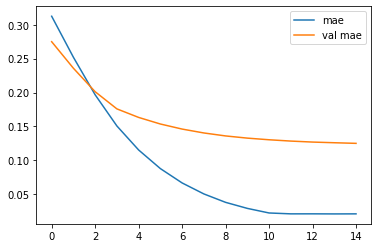

In [46]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 5s 29ms/step
124.65222 1.0630075 135.2005238178647


,actual,prediction
0,11800,11878.652344
1,11800,11878.785156
2,11800,11878.518555
3,11800,11878.620117
4,11750,11878.321289
...,...,...
229,11800,11875.208984
230,11800,11875.024414
231,11800,11875.070312
232,11750,11874.997070


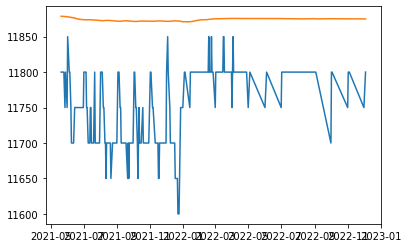

In [47]:
prediction1_a = forecast_predict(model1_a, test_beras_medium1_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_beras_medium11_a = pd.DataFrame()
data_new_beras_medium11_a['actual'] = x_test
data_new_beras_medium11_a['prediction'] = data_result1_a
data_new_beras_medium11_a.to_csv('beras_medium1_model2_sgd_type1.csv')


plt.plot(y_test, data_new_beras_medium11_a.actual)
plt.plot(y_test, data_new_beras_medium11_a.prediction)

data_new_beras_medium11_a

#### Type 2


In [48]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 27s 38ms/step - loss: 0.0037 - mae: 0.0415 - mape: 12.3222 - val_loss: 0.0253 - val_mae: 0.1261 - val_mape: 53623996.0000
Epoch 2/15
718/718 [==============================] - 26s 36ms/step - loss: 0.0037 - mae: 0.0414 - mape: 12.2828 - val_loss: 0.0253 - val_mae: 0.1260 - val_mape: 53652084.0000
Epoch 3/15
718/718 [==============================] - 26s 37ms/step - loss: 0.0037 - mae: 0.0414 - mape: 12.3089 - val_loss: 0.0253 - val_mae: 0.1265 - val_mape: 53453264.0000
Epoch 4/15
718/718 [==============================] - 26s 37ms/step - loss: 0.0037 - mae: 0.0414 - mape: 12.2919 - val_loss: 0.0253 - val_mae: 0.1267 - val_mape: 53382504.0000
Epoch 5/15
718/718 [==============================] - 26s 37ms/step - loss: 0.0037 - mae: 0.0410 - mape: 12.1244 - val_loss: 0.0254 - val_mae: 0.1250 - val_mape: 54037564.0000
Epoch 6/15
718/718 [==============================] - 26s 37ms/step - loss: 0.0037 - mae: 0.0415 - mape: 12.3317 - val_l

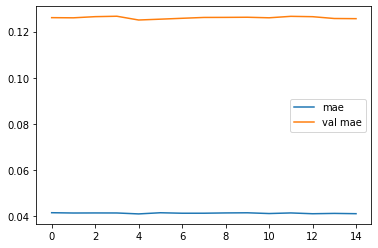

In [49]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 7ms/step
120.35517 1.0264318 131.23906204423284


,actual,prediction
0,11800,11874.803711
1,11800,11874.909180
2,11800,11874.649414
3,11800,11874.712891
4,11750,11874.421875
...,...,...
229,11800,11870.813477
230,11800,11870.631836
231,11800,11870.677734
232,11750,11870.609375


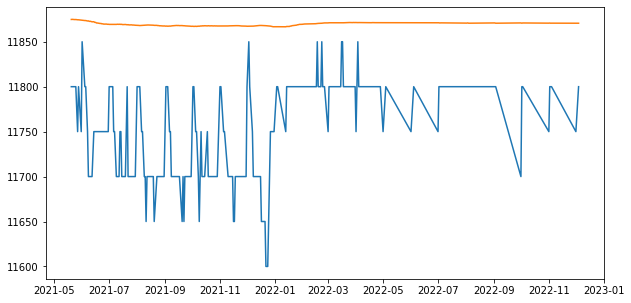

In [50]:
prediction1_a1 = forecast_predict(model1_a, test_beras_medium1_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_beras_medium11_a1 = pd.DataFrame()
data_new_beras_medium11_a1['actual'] = x_test
data_new_beras_medium11_a1['prediction'] = data_result1_a1
data_new_beras_medium11_a1.to_csv('beras_medium1_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_medium11_a1.actual)
plt.plot(y_test, data_new_beras_medium11_a1.prediction)
data_new_beras_medium11_a1

#### Type 3

In [51]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 16s 184ms/step - loss: 0.0028 - mae: 0.0318 - mape: 10.0122 - val_loss: 0.0253 - val_mae: 0.1269 - val_mape: 53307640.0000
Epoch 2/15
84/84 [==============================] - 16s 183ms/step - loss: 0.0028 - mae: 0.0308 - mape: 9.6107 - val_loss: 0.0252 - val_mae: 0.1276 - val_mape: 53021476.0000
Epoch 3/15
84/84 [==============================] - 15s 182ms/step - loss: 0.0028 - mae: 0.0299 - mape: 9.2780 - val_loss: 0.0252 - val_mae: 0.1281 - val_mape: 52831288.0000
Epoch 4/15
84/84 [==============================] - 15s 182ms/step - loss: 0.0028 - mae: 0.0300 - mape: 9.2988 - val_loss: 0.0252 - val_mae: 0.1282 - val_mape: 52784152.0000
Epoch 5/15
84/84 [==============================] - 15s 181ms/step - loss: 0.0028 - mae: 0.0298 - mape: 9.2434 - val_loss: 0.0252 - val_mae: 0.1284 - val_mape: 52690612.0000
Epoch 6/15
84/84 [==============================] - 15s 182ms/step - loss: 0.0028 - mae: 0.0296 - mape: 9.1374 - val_loss: 0.0252

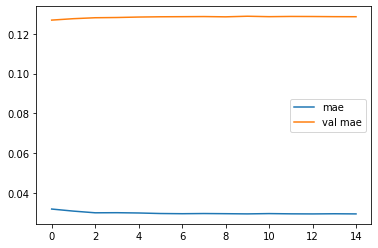

In [52]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 13ms/step
105.40378 0.89917 117.66056183998103


,actual,prediction
0,11800,11860.016602
1,11800,11860.122070
2,11800,11859.862305
3,11800,11859.927734
4,11750,11859.636719
...,...,...
229,11800,11855.949219
230,11800,11855.816406
231,11800,11855.827148
232,11750,11855.785156


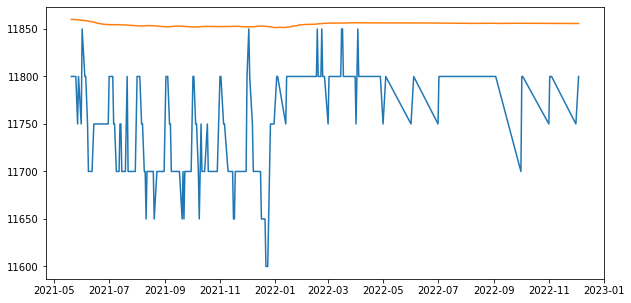

In [53]:
prediction1_a2 = forecast_predict(model1_a, test_beras_medium1_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_beras_medium11_a2 = pd.DataFrame()
data_new_beras_medium11_a2['actual'] = x_test
data_new_beras_medium11_a2['prediction'] = data_result1_a2
data_new_beras_medium11_a2.to_csv('beras_medium1_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_medium11_a2.actual)
plt.plot(y_test, data_new_beras_medium11_a2.prediction)

data_new_beras_medium11_a2

## model 2

### SGD

In [54]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [55]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [56]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 9s 117ms/step - loss: 0.0989 - mae: 0.3130 - mape: 92.7061 - val_loss: 0.0940 - val_mae: 0.2792 - val_mape: 8227707.0000
Epoch 2/50
44/44 [==============================] - 4s 99ms/step - loss: 0.0704 - mae: 0.2635 - mape: 77.8999 - val_loss: 0.0712 - val_mae: 0.2471 - val_mape: 15973457.0000
Epoch 3/50
44/44 [==============================] - 4s 97ms/step - loss: 0.0493 - mae: 0.2200 - mape: 64.9682 - val_loss: 0.0558 - val_mae: 0.2203 - val_mape: 22398896.0000
Epoch 4/50
44/44 [==============================] - 4s 96ms/step - loss: 0.0344 - mae: 0.1833 - mape: 54.0551 - val_loss: 0.0452 - val_mae: 0.1977 - val_mape: 27825044.0000
Epoch 5/50
44/44 [==============================] - 4s 96ms/step - loss: 0.0241 - mae: 0.1526 - mape: 44.9029 - val_loss: 0.0379 - val_mae: 0.1786 - val_mape: 32433138.0000
Epoch 6/50
44/44 [==============================] - 4s 96ms/step - loss: 0.0168 - mae: 0.1262 - mape: 37.0145 - val_loss: 0.0331 - val_

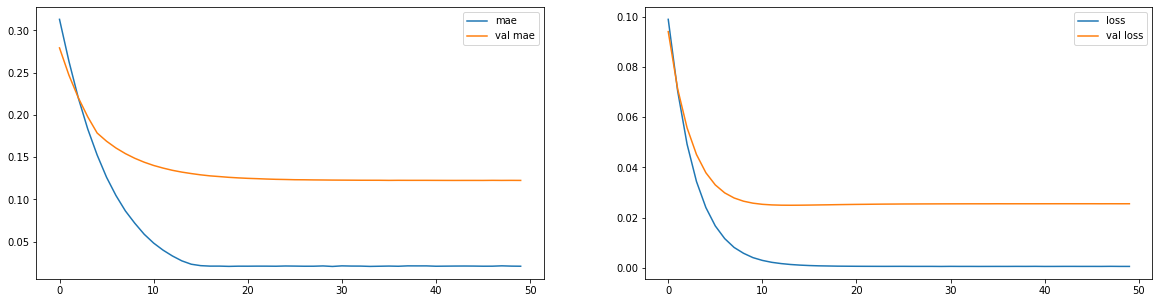

In [57]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 3s 13ms/step
137.77516 1.1747148 147.49677565331726


,actual,prediction
0,11800,11893.250000
1,11800,11893.364258
2,11800,11893.451172
3,11800,11893.170898
4,11750,11893.117188
...,...,...
229,11800,11888.236328
230,11800,11888.294922
231,11800,11888.300781
232,11750,11888.410156


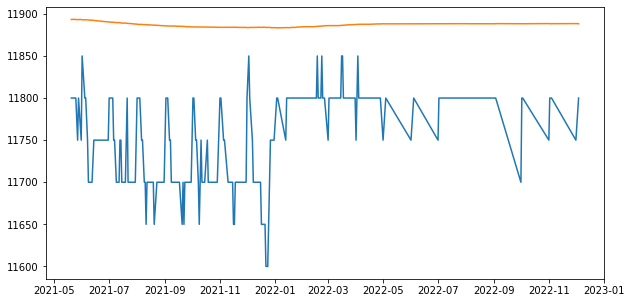

In [58]:
prediction2 = forecast_predict(model2, test_beras_medium1_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_beras_medium12 = pd.DataFrame()
data_new_beras_medium12['actual'] = x_test
data_new_beras_medium12['prediction'] = data_result2
data_new_beras_medium12.to_csv('beras_medium1_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_medium12.actual)
plt.plot(y_test, data_new_beras_medium12.prediction)
data_new_beras_medium12

#### Type2

In [59]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 13s 18ms/step - loss: 0.0038 - mae: 0.0425 - mape: 12.7400 - val_loss: 0.0252 - val_mae: 0.1262 - val_mape: 53364708.0000
Epoch 2/50
718/718 [==============================] - 14s 19ms/step - loss: 0.0038 - mae: 0.0422 - mape: 12.5304 - val_loss: 0.0252 - val_mae: 0.1265 - val_mape: 53282124.0000
Epoch 3/50
718/718 [==============================] - 13s 17ms/step - loss: 0.0038 - mae: 0.0417 - mape: 12.3179 - val_loss: 0.0252 - val_mae: 0.1263 - val_mape: 53347624.0000
Epoch 4/50
718/718 [==============================] - 13s 18ms/step - loss: 0.0038 - mae: 0.0420 - mape: 12.4682 - val_loss: 0.0252 - val_mae: 0.1261 - val_mape: 53401200.0000
Epoch 5/50
718/718 [==============================] - 13s 18ms/step - loss: 0.0038 - mae: 0.0418 - mape: 12.4094 - val_loss: 0.0252 - val_mae: 0.1266 - val_mape: 53222136.0000
Epoch 6/50
718/718 [==============================] - 12s 17ms/step - loss: 0.0038 - mae: 0.0419 - mape: 12.4164 - val_l

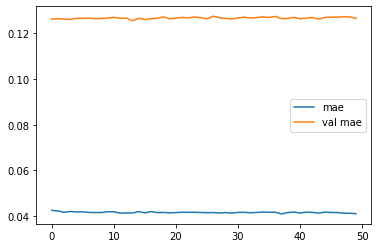

In [60]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [61]:
prediction2_1 = forecast_predict(model2, test_beras_medium1_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_beras_medium12_1 = pd.DataFrame()
data_new_beras_medium12_1['actual'] = x_test
data_new_beras_medium12_1['prediction'] = data_result2_1
data_new_beras_medium12_1.to_csv('beras_medium1_model3_sgd_type2.csv')

data_new_beras_medium12

199/199 [==============================] - 1s 3ms/step
121.02532 1.0321445 131.94180772219244


,actual,prediction
0,11800,11893.250000
1,11800,11893.364258
2,11800,11893.451172
3,11800,11893.170898
4,11750,11893.117188
...,...,...
229,11800,11888.236328
230,11800,11888.294922
231,11800,11888.300781
232,11750,11888.410156


#### Type 3

In [62]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 6s 67ms/step - loss: 0.0028 - mae: 0.0316 - mape: 9.9208 - val_loss: 0.0252 - val_mae: 0.1273 - val_mape: 52999500.0000
Epoch 2/50
84/84 [==============================] - 6s 65ms/step - loss: 0.0028 - mae: 0.0308 - mape: 9.6300 - val_loss: 0.0251 - val_mae: 0.1278 - val_mape: 52805308.0000
Epoch 3/50
84/84 [==============================] - 6s 71ms/step - loss: 0.0028 - mae: 0.0306 - mape: 9.5532 - val_loss: 0.0251 - val_mae: 0.1282 - val_mape: 52637924.0000
Epoch 4/50
84/84 [==============================] - 6s 68ms/step - loss: 0.0028 - mae: 0.0302 - mape: 9.3870 - val_loss: 0.0251 - val_mae: 0.1287 - val_mape: 52457148.0000
Epoch 5/50
84/84 [==============================] - 6s 68ms/step - loss: 0.0028 - mae: 0.0300 - mape: 9.2990 - val_loss: 0.0251 - val_mae: 0.1289 - val_mape: 52374948.0000
Epoch 6/50
84/84 [==============================] - 6s 70ms/step - loss: 0.0028 - mae: 0.0297 - mape: 9.1698 - val_loss: 0.0251 - val_mae: 0

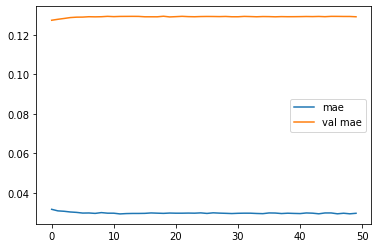

In [63]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [64]:
prediction2_2 = forecast_predict(model2, test_beras_medium1_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_beras_medium12_2 = pd.DataFrame()
data_new_beras_medium12_2['actual'] = x_test
data_new_beras_medium12_2['prediction'] = data_result2_2
data_new_beras_medium12_2.to_csv('beras_medium1_model3_sgd-type3.csv')

data_new_beras_medium12_2

181/181 [==============================] - 1s 7ms/step
106.62343 0.9095569 118.81688494670065


,actual,prediction
0,11800,11860.102539
1,11800,11859.835938
2,11800,11859.819336
3,11800,11859.831055
4,11750,11859.851562
...,...,...
229,11800,11857.136719
230,11800,11857.210938
231,11800,11857.104492
232,11750,11857.156250


### Adam

In [75]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_12 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_2 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_13 (LSTM)              (None, 80)                33600     
                                                                 
 dense_16 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [66]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 10s 134ms/step - loss: 0.0974 - mae: 0.3104 - mape: 91.9275 - val_loss: 0.0877 - val_mae: 0.2709 - val_mape: 10250260.0000
Epoch 2/50
44/44 [==============================] - 5s 108ms/step - loss: 0.0306 - mae: 0.1467 - mape: 42.9088 - val_loss: 0.0353 - val_mae: 0.1730 - val_mape: 34443252.0000
Epoch 3/50
44/44 [==============================] - 5s 108ms/step - loss: 0.0015 - mae: 0.0302 - mape: 8.6772 - val_loss: 0.0323 - val_mae: 0.1663 - val_mape: 37101272.0000
Epoch 4/50
44/44 [==============================] - 5s 109ms/step - loss: 8.3305e-04 - mae: 0.0232 - mape: 6.7775 - val_loss: 0.0330 - val_mae: 0.1680 - val_mape: 36459772.0000
Epoch 5/50
44/44 [==============================] - 5s 109ms/step - loss: 9.7554e-04 - mae: 0.0250 - mape: 7.2495 - val_loss: 0.0324 - val_mae: 0.1665 - val_mape: 37031368.0000
Epoch 6/50
44/44 [==============================] - 5s 112ms/step - loss: 0.0010 - mae: 0.0256 - mape: 7.4451 - val_loss: 0.

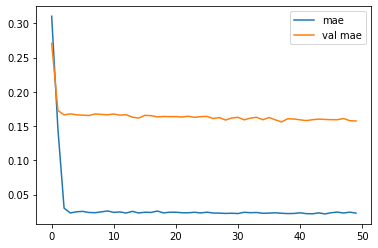

In [67]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [68]:
prediction2_a = forecast_predict(model2_a, test_beras_medium1_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_beras_medium12_a = pd.DataFrame()
data_new_beras_medium12_a['actual'] = x_test
data_new_beras_medium12_a['prediction'] = data_result2_a
data_new_beras_medium12_a.to_csv('beras_medium1_model3_adam-type1.csv')

data_new_beras_medium12_a

131/131 [==============================] - 3s 14ms/step
112.503525 0.9597225 126.09221653342644


,actual,prediction
0,11800,11888.286133
1,11800,11889.127930
2,11800,11888.450195
3,11800,11889.058594
4,11750,11887.815430
...,...,...
229,11800,11854.196289
230,11800,11854.264648
231,11800,11854.166992
232,11750,11854.887695


#### Type 2

In [69]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 15s 20ms/step - loss: 0.0046 - mae: 0.0433 - mape: 12.6133 - val_loss: 0.0251 - val_mae: 0.1307 - val_mape: 51543348.0000
Epoch 2/50
718/718 [==============================] - 14s 19ms/step - loss: 0.0041 - mae: 0.0421 - mape: 12.3720 - val_loss: 0.0250 - val_mae: 0.1320 - val_mape: 51058524.0000
Epoch 3/50
718/718 [==============================] - 13s 19ms/step - loss: 0.0039 - mae: 0.0409 - mape: 12.0441 - val_loss: 0.0250 - val_mae: 0.1339 - val_mape: 50346536.0000
Epoch 4/50
718/718 [==============================] - 14s 20ms/step - loss: 0.0039 - mae: 0.0411 - mape: 12.1087 - val_loss: 0.0251 - val_mae: 0.1292 - val_mape: 52275152.0000
Epoch 5/50
718/718 [==============================] - 14s 19ms/step - loss: 0.0037 - mae: 0.0402 - mape: 11.8917 - val_loss: 0.0251 - val_mae: 0.1308 - val_mape: 51703804.0000
Epoch 6/50
718/718 [==============================] - 14s 19ms/step - loss: 0.0035 - mae: 0.0390 - mape: 11.5678 - val_l

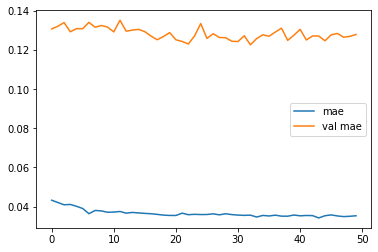

In [70]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
138.4279 1.180131 147.10006691874753


,actual,prediction
0,11800,11902.647461
1,11800,11902.575195
2,11800,11900.266602
3,11800,11900.395508
4,11750,11900.871094
...,...,...
229,11800,11885.358398
230,11800,11884.100586
231,11800,11885.324219
232,11750,11884.073242


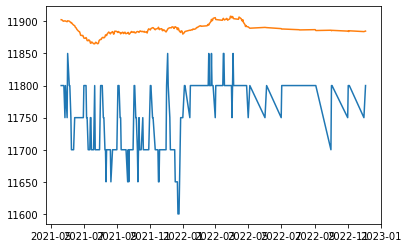

In [71]:
prediction2_a1 = forecast_predict(model2_a, test_beras_medium1_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_beras_medium12_a1 = pd.DataFrame()
data_new_beras_medium12_a1['actual'] = x_test
data_new_beras_medium12_a1['prediction'] = data_result2_a1
data_new_beras_medium12_a1.to_csv('beras_medium1_model3_adam-type2.csv')

plt.plot(y_test, data_new_beras_medium12_a1.actual)
plt.plot(y_test, data_new_beras_medium12_a1.prediction)
data_new_beras_medium12_a1

#### Type 3

In [72]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 6s 74ms/step - loss: 0.0027 - mae: 0.0275 - mape: 8.4979 - val_loss: 0.0255 - val_mae: 0.1306 - val_mape: 52517160.0000
Epoch 2/50
84/84 [==============================] - 6s 73ms/step - loss: 0.0026 - mae: 0.0268 - mape: 8.2277 - val_loss: 0.0256 - val_mae: 0.1291 - val_mape: 53197340.0000
Epoch 3/50
84/84 [==============================] - 6s 75ms/step - loss: 0.0026 - mae: 0.0266 - mape: 8.1320 - val_loss: 0.0257 - val_mae: 0.1288 - val_mape: 53383480.0000
Epoch 4/50
84/84 [==============================] - 6s 73ms/step - loss: 0.0026 - mae: 0.0278 - mape: 8.6380 - val_loss: 0.0255 - val_mae: 0.1312 - val_mape: 52341056.0000
Epoch 5/50
84/84 [==============================] - 6s 73ms/step - loss: 0.0026 - mae: 0.0268 - mape: 8.2232 - val_loss: 0.0258 - val_mae: 0.1280 - val_mape: 53709880.0000
Epoch 6/50
84/84 [==============================] - 6s 73ms/step - loss: 0.0027 - mae: 0.0270 - mape: 8.2943 - val_loss: 0.0256 - val_mae: 0

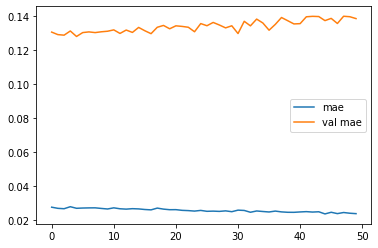

In [73]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 8ms/step
127.19875 1.0829328 141.19586213616532


,actual,prediction
0,11800,11861.597656
1,11800,11861.969727
2,11800,11864.624023
3,11800,11862.726562
4,11750,11859.560547
...,...,...
229,11800,11986.474609
230,11800,11979.583008
231,11800,11979.663086
232,11750,11981.569336


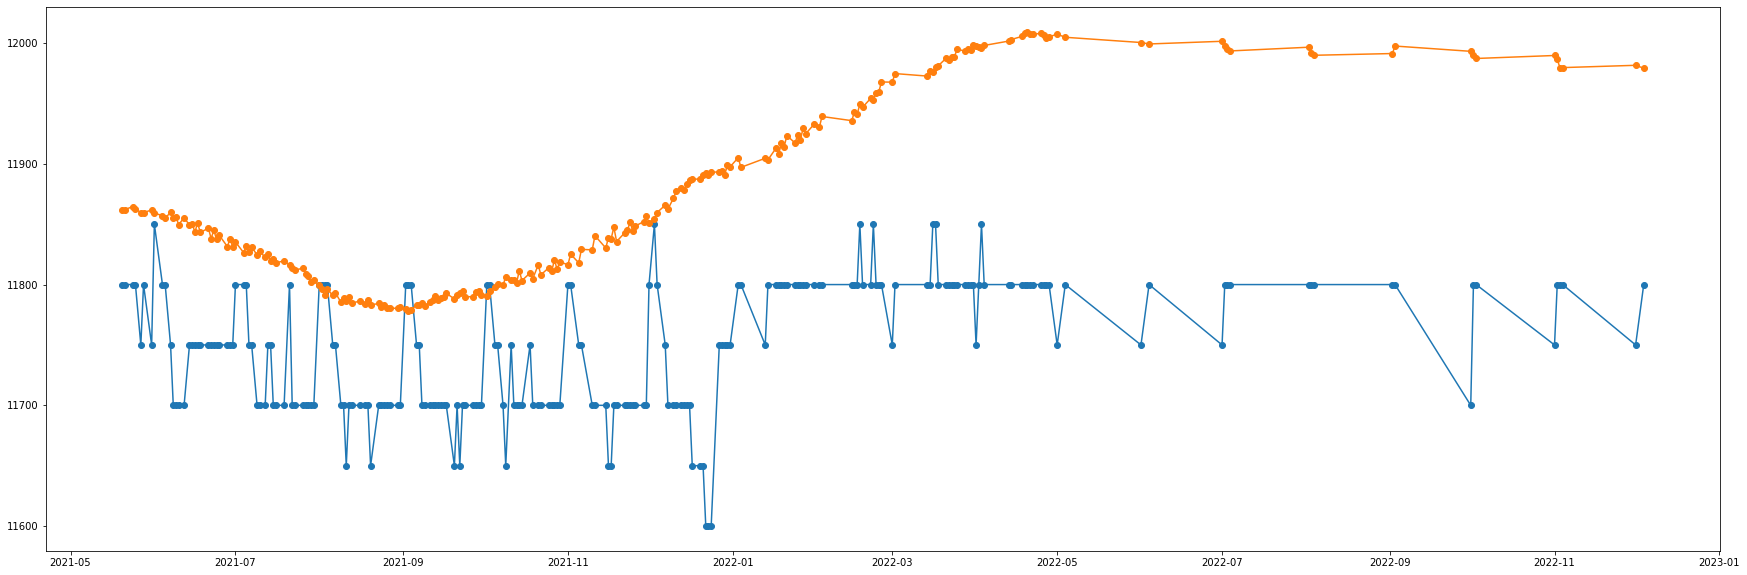

In [74]:
prediction2_a2 = forecast_predict(model2_a, test_beras_medium1_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_beras_medium12_a2 = pd.DataFrame()
data_new_beras_medium12_a2['actual'] = x_test
data_new_beras_medium12_a2['prediction'] = data_result2_a2
data_new_beras_medium12_a2.to_csv('beras_medium1_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_beras_medium12_a2.actual, '-o')
plt.plot(y_test,data_new_beras_medium12_a2.prediction, '-o')
data_new_beras_medium12_a2